In [1]:
import msprime
import tskit
import numpy as np

import os
import subprocess

import pandas as pd

import math 
import statistics

import seaborn as sns
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt

from collections import Counter

### Estimating expected branch lengths under the IM model

##### Set up a branch type dictionary for the unphased unrooted IM model
##### Keys are lists of lineages which share a derived mutation, values are mutation types (see Laetsch et al. 2023)

In [2]:
HetATypes = [ # when a mutation is ancestral to any of these lists of leaves, it is a hetA mutation
    [0],
    [1],
    [0,2,3], # [0, 2, 3] is equivalent to [1] on an unrooted tree
    [1,2,3]
]
HetBTypes = [
    [2],
    [3],
    [0,1,2],
    [0,1,3]
]
FixedDiffs = [
    [0,1],
    [2,3]
]
HetABTypes = [
    [0,2],
    [0,3],
    [1,2],
    [1,3]
]

mutTypeDict = {(0,1,2,3):None};
for ls in HetATypes:
    mutTypeDict[tuple(sorted(ls))] = "hetA"
for ls in HetBTypes:
    mutTypeDict[tuple(sorted(ls))] = "hetB"
for ls in HetABTypes:
    mutTypeDict[tuple(sorted(ls))] = "hetAB"
for ls in FixedDiffs:
    mutTypeDict[tuple(sorted(ls))] = "FD"

mutTypeDict


{(0, 1, 2, 3): None,
 (0,): 'hetA',
 (1,): 'hetA',
 (0, 2, 3): 'hetA',
 (1, 2, 3): 'hetA',
 (2,): 'hetB',
 (3,): 'hetB',
 (0, 1, 2): 'hetB',
 (0, 1, 3): 'hetB',
 (0, 2): 'hetAB',
 (0, 3): 'hetAB',
 (1, 2): 'hetAB',
 (1, 3): 'hetAB',
 (0, 1): 'FD',
 (2, 3): 'FD'}

##### Set up simulations for the IM model with various parameters, add mutations, then show the first tree

In [3]:
mu = 1e-8
r = 0 # assume no recombination for now
Na = 1e5
Nb = 1e5
Nanc = 1e5
M = 1.0 / (2 * Na)
Tsplit = 2e5 #generations

L = int(1e4)
block_length = 200

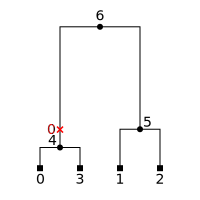

In [4]:
mts_list = []

demography = msprime.Demography()
demography.add_population(name="A", initial_size=Na)
demography.add_population(name="B", initial_size=Nb)
demography.add_population(name="C", initial_size=Nanc)
demography.add_population_split(time=Tsplit, derived=["A", "B"], ancestral="C")
demography.set_migration_rate(source="A",dest="B",rate = M)

ts_reps = msprime.sim_ancestry(
    samples={"A": 1, "B": 1}, 
    demography=demography,
    ploidy=2,
    recombination_rate=0,
    sequence_length=block_length,
    discrete_genome=False,
    random_seed = 44,
    num_replicates = int(L / block_length)
)

for i, ts in enumerate(ts_reps): 
    mts_list.append(msprime.sim_mutations(ts, rate=mu, discrete_genome=False, random_seed = 100))
    
    if i == 0:
        first_tree = mts_list[i].first()

first_tree.draw_svg()

##### As an example, summarise the mutations on this tree

In [5]:
tempList = []
for node in first_tree.nodes():
    leaves = tuple(sorted(list(first_tree.leaves(node))))
    mutType = mutTypeDict[leaves]
    length = first_tree.get_branch_length(node)
    tempList.append([mutType,length,node])
if 'hetAB' in [a for (a,b,c) in tempList]:
    print("hetAB mutation? Yes")
else:
    print("hetAB mutation? No")
hetA = [[a,b] for a,b,c in tempList if a=='hetA']
hetB = [[a,b] for a,b,c in tempList if a=='hetB']
branchLengthA = sum([b for a,b in hetA])
branchLengthB = sum([b for a,b in hetB])
print("Sums of a branches (sample of tau_a): ", branchLengthA)
print("Sums of b branches (sample of tau_b): ", branchLengthB)

hetAB mutation? Yes
Sums of a branches (sample of tau_a):  294255.05229381763
Sums of b branches (sample of tau_b):  294255.05229381763


#### Now we want to record external branch lengths in three different contexts
- all genealogies (idx 0)
- incongruent genealogies (idx 1)
- incongruent genealogies with hetAB mutations (idx 2)

##### Calculate the store the branch lengths, returning lists for each of the above

In [6]:
def record_branch_lengths(mts_list):

    a_0_lengths = []
    b_0_lengths = []

    a_1_lengths = []
    b_1_lengths = []

    a_2_lengths = []
    b_2_lengths = []
    
    for mts in mts_list:

        tree = mts.at(block_length / 2) # assuming no recombination in a block, it doesn't matter where we sample from
     
        tempList = []
        for node in tree.nodes():
            leaves = tuple(sorted(list(tree.leaves(node))))
            mutType = mutTypeDict[leaves]
            length = tree.get_branch_length(node)
            tempList.append([mutType,length])
    
        # calculate the total length of hetA and hetB type branches in this tree
        a_length = sum([y for x,y in tempList if x=='hetA'])
        b_length = sum([y for x,y in tempList if x=='hetB'])
    
        # record the hetA and hetB branch lengths for all trees
        a_0_lengths.append(a_length)
        b_0_lengths.append(b_length)
    
    
        # if the topology is incongruent, 
        if 'hetAB' in [a for (a,b) in tempList]:
            
            #store the hetA and hetB branch lengths for this tree conditioned on incongruence
            a_1_lengths.append(a_length)
            b_1_lengths.append(b_length)
    
            # given incongruence, check if there is a hetAB mutation present within the block
            has_ab_mut = False
            muts = tree.mutations()
            for mut in muts:
                # get the node below the mutation and check the branch type (mutType) of the mutation
                node1 = mut.node
                leaves = tuple(sorted(list(tree.leaves(node1))))
                mutType = mutTypeDict[leaves]
                # if the mutation is hetAB
                if mutType == 'hetAB':
                    has_ab_mut = True
                    break
                            
            # conditioned on a hetAB mutation in the block, record the hetA and hetB branch lengths 
            if has_ab_mut:
                a_2_lengths.append(a_length)
                b_2_lengths.append(b_length)

    return a_0_lengths, b_0_lengths, a_1_lengths, b_1_lengths, a_2_lengths, b_2_lengths

In [7]:
a_0_lengths, b_0_lengths, a_1_lengths, b_1_lengths, a_2_lengths, b_2_lengths = record_branch_lengths(mts_list)

##### These lists of external branch lengths can be summarised in terms of asymmetry (A_i and A_m)

In [8]:
def calculate_asymmetry(a_list, b_list):
    
    a_total = sum(a_list)
    b_total = sum(b_list)

    asymm = (a_total - b_total) / (a_total + b_total)

    return asymm

In [9]:
print("A for all genealogies: ", "\t\t\t\t", calculate_asymmetry(a_0_lengths, b_0_lengths))
print("A_i for incongruent genealogies: ", "\t\t\t", calculate_asymmetry(a_1_lengths, b_1_lengths))
print("A_m for incongruent genealogies with hetAB mutations: ", "\t", calculate_asymmetry(a_2_lengths, b_2_lengths))

A for all genealogies:  				 0.12565851306521508
A_i for incongruent genealogies:  			 0.034984076412470325
A_m for incongruent genealogies with hetAB mutations:  	 0.0


##### We can use the code above to obtain point estimates of A_m. To obtain the variance of the estimate, and therefore 95%CIs, we can perform block jackknife resampling.

In [10]:
def block_jackknife(a_list, b_list, jk_block):
    total_jk_blocks = int((len(a_list) - (len(a_list) % jk_block)) / jk_block)
    if total_jk_blocks < 2:
        #print("not enough blocks for jackknife")
        overall_estimate = calculate_asymmetry(a_list, b_list)
        return [-1, overall_estimate, 1]
    trimmed_a_list = a_list[:total_jk_blocks * jk_block]
    trimmed_b_list = b_list[:total_jk_blocks * jk_block]
    blocked_a_list = np.mean(trimmed_a_list.reshape(-1, jk_block), axis=1)
    blocked_b_list = np.mean(trimmed_b_list.reshape(-1, jk_block), axis=1)
    overall_estimate = calculate_asymmetry(blocked_a_list, blocked_b_list)
    n = total_jk_blocks
    pseudo_estimates = []
    for i in range(0, n):
        retained_a_blocks = np.delete(blocked_a_list, i)
        retained_b_blocks = np.delete(blocked_b_list, i)
        retained_blocks_estimate = calculate_asymmetry(retained_a_blocks, retained_b_blocks)
        pseudo_estimate = (n * overall_estimate) - ((n - 1) * retained_blocks_estimate)
        pseudo_estimates.append(pseudo_estimate)
    pseudovalue_variance = sum([(e - overall_estimate)**2 for e in pseudo_estimates]) / (n - 1)
    lower_CI = overall_estimate - (1.96 * math.sqrt(pseudovalue_variance / n))
    higher_CI = overall_estimate + (1.96 * math.sqrt(pseudovalue_variance / n))
    return [lower_CI, overall_estimate, higher_CI]

##### Now we can simulate many blocks (e.g. 500,000) to generate approximate expectations for A, A_i and A_m. Simulations do not need to follow the five parameter IM model and can instead include bidirectional migration or other processes.

In [11]:
mu = 1e-8
r = 0
Na = 1e5
Nb = 1e5
Nanc = 1e5
Ma = 1 / (2 * Na)
Mb = 0 / (2 * Nb)
Tsplit = 2e5 #generations

L = int(1e6)
block_length = 200

a_reps_0_list = []
b_reps_0_list = []
a_reps_1_list = []
b_reps_1_list = []
a_reps_2_list = []
b_reps_2_list = []

for i in range(0, 5): # actual sims include 100 tree sequences

    mts_list = []

    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=Na)
    demography.add_population(name="B", initial_size=Nb)
    demography.add_population(name="C", initial_size=Nanc)
    demography.add_population_split(time=Tsplit, derived=["A", "B"], ancestral="C")
    demography.set_migration_rate(source="A",dest="B",rate = Ma)
    demography.set_migration_rate(source="B",dest="A",rate = Mb)
    
    ts_reps = msprime.sim_ancestry(
        samples={"A": 1, "B": 1}, 
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=block_length,
        discrete_genome=False,
        random_seed = 44+i,
        num_replicates = int(L / block_length)
    )
    
    for i, ts in enumerate(ts_reps): 
        mts_list.append(msprime.sim_mutations(ts, rate=mu, discrete_genome=False, random_seed = 44+i))

    a_0_lengths, b_0_lengths, a_1_lengths, b_1_lengths, a_2_lengths, b_2_lengths = record_branch_lengths(mts_list)

    a_reps_0_list.append(sum(a_0_lengths)) # this groups replicates from the same mts together
    b_reps_0_list.append(sum(b_0_lengths)) # the 100 jackknife blocks will be weighted equally, which is only appropriate for large samples
    a_reps_1_list.append(sum(a_1_lengths))
    b_reps_1_list.append(sum(b_1_lengths))
    a_reps_2_list.append(sum(a_2_lengths))
    b_reps_2_list.append(sum(b_2_lengths))

    print("A for all genealogies in block: ", "\t\t\t\t", calculate_asymmetry(a_0_lengths, b_0_lengths))
    print("A for incongruent genealogies in block: ", "\t\t\t", calculate_asymmetry(a_1_lengths, b_1_lengths))
    print("A for incongruent genealogies with hetAB mutations in block: ", "\t", calculate_asymmetry(a_2_lengths, b_2_lengths))

    print("................................................................")

    print("................. Running estimates so far .....................")

    print(block_jackknife(np.array(a_reps_0_list), np.array(b_reps_0_list), 1)) # ensures 100 (unweighted) jackknife blocks 
    print(block_jackknife(np.array(a_reps_1_list), np.array(b_reps_1_list), 1))
    print(block_jackknife(np.array(a_reps_2_list), np.array(b_reps_2_list), 1))

    print("----------------------------------------------------------------")

A for all genealogies in block:  				 0.16575491363320535
A for incongruent genealogies in block:  			 0.12537885856889383
A for incongruent genealogies with hetAB mutations in block:  	 0.049175283546627244
................................................................
................. Running estimates so far .....................
[-1, 0.16575491363320535, 1]
[-1, 0.12537885856889383, 1]
[-1, 0.049175283546627244, 1]
----------------------------------------------------------------
A for all genealogies in block:  				 0.15517415536226334
A for incongruent genealogies in block:  			 0.1053863576755524
A for incongruent genealogies with hetAB mutations in block:  	 0.01340208064969981
................................................................
................. Running estimates so far .....................
[0.15004762120098866, 0.16041717969893562, 0.1707867381968826]
[0.09571292923723743, 0.11530615316453796, 0.1348993770918385]
[-0.004731331530162596, 0.030372379136541183, 0

##### We also simulate longer sequences with recombination. These sequences can be split into blocks of size 2^n, allowing for (non-independent) estimates of A_m across a range of block sizes.

100
jack-knifing...


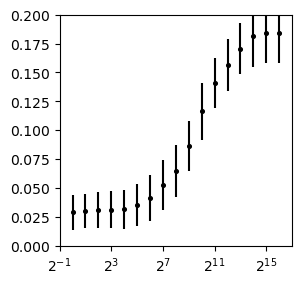

CPU times: total: 26 s
Wall time: 31.8 s


In [14]:
%%time

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

mu = 1e-8
r = 1e-8
Na = 1e5
Nb = 1e5
Nanc = 1e5
M = 1.0 / (2 * Na)
Tsplit = 2e5 #generations
L = 65_536

a_results_dict = {}
b_results_dict = {}
for dist in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16_384, 32_768, 65_536]:
    a_results_dict[dist] = np.array([], dtype=np.float64)
    b_results_dict[dist] = np.array([], dtype=np.float64)


def a_b_from_tree(tree):
    tempList = []
    for node in tree.nodes():
        leaves = tuple(sorted(list(tree.leaves(node))))
        mutType = mutTypeDict[leaves]
        length = tree.get_branch_length(node)
        tempList.append([mutType,length])

    # calculate the total length of hetA and hetB type branches in this tree
    a_length = sum([y for x,y in tempList if x=='hetA'])
    b_length = sum([y for x,y in tempList if x=='hetB'])

    return a_length, b_length


for i in range(1, 101): # this would normally be 5001

    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=Na)
    demography.add_population(name="B", initial_size=Nb)
    demography.add_population(name="C", initial_size=Nanc)
    demography.add_population_split(time=Tsplit, derived=["A", "B"], ancestral="C")
    demography.set_migration_rate(source="A",dest="B",rate = M)
    
    ts = msprime.sim_ancestry(
        samples={"A": 1, "B": 1}, 
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=True, # means genelogies have defined coords
        random_seed = 44+i,
        record_migrations=True
    )

    mt_ts = msprime.sim_mutations(ts, rate=mu, discrete_genome=False, random_seed = 44+i)

    seq_a_length = []
    seq_b_length = []
    hetAB = [0] * L
    
    for tree in mt_ts.trees():
        
        start = tree.interval.left
        end = tree.interval.right
        span = int(end - start)
        a_length, b_length = a_b_from_tree(tree)
        seq_a_length = seq_a_length + ([a_length] * span)
        seq_b_length = seq_b_length + ([b_length] * span)
        for site in tree.sites():
            mut_pos = int(site.position) # we are still using infinite sites here as we record the mutation rather than the alleles
            leaves = tuple(sorted(list(tree.leaves(site.mutations[0].node))))
            mutType = mutTypeDict[leaves]
            if mutType == "hetAB":
                hetAB[mut_pos] = 1

    
    for dist in a_results_dict.keys():
        for interval_start in range(0, L, dist):
            interval_hetAB = hetAB[interval_start:interval_start+dist]
            if sum(interval_hetAB) > 0:
                interval_res_a = seq_a_length[interval_start:interval_start+dist]
                interval_res_b = seq_b_length[interval_start:interval_start+dist]
                interval_a = sum(interval_res_a) / len(interval_res_a)
                interval_b = sum(interval_res_b) / len(interval_res_b)
                a_results_dict[dist] = np.append(a_results_dict[dist], np.array([interval_a]))
                b_results_dict[dist] = np.append(b_results_dict[dist], np.array([interval_b]))


    if i % 100 == 0 and i > 0: # this would normally be 5000
        print(i)


        dist_list = []
        asymm_list_l = []
        asymm_list_p = []
        asymm_list_u = []
        topology_list = []
        
        print("jack-knifing...")
        
        for dist in a_results_dict.keys():
            if len(a_results_dict[dist]) > 0:
                jk_block = int(round((len(a_results_dict[dist]) / 25), 0)) # ensures 25 blocks
                dist_list.append(dist)
                lower, point, upper = block_jackknife(a_results_dict[dist], b_results_dict[dist], jk_block)
                asymm_list_l.append(lower)
                asymm_list_p.append(point)
                asymm_list_u.append(upper)
                
        fig, ax = plt.subplots()
        fig.set_size_inches(3, 3)
        ax.scatter(x = dist_list, y = asymm_list_p, s=7, color="k")
        ax.errorbar(x = dist_list, y = asymm_list_p, yerr = np.subtract(asymm_list_p, asymm_list_l), color="k", ls='none')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.set_xscale('log', base=2)
        ax.set_xlim(0.5, 2*L)
        ax.set_ylim(0, 0.2)
        ax.set_xscale('log', base=2)
        plt.show()